In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
from typing import TypedDict, List, Annotated

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.
"""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed:

-------
{content}
"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests  for length, depth, style, etc.
"""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""

In [5]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [7]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [8]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [9]:
def generation_node(state: AgentState):
    content = "\n\n".join(state.get("content", []))
    user_message = HumanMessage(content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message
    ]

    response = model.invoke(messages)
    return {"draft": response.content, 
            "revision_number": state.get("revision_number", 1) + 1}

In [10]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [11]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state["critique"])
    ])

    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [12]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [13]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [14]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=MemorySaver())

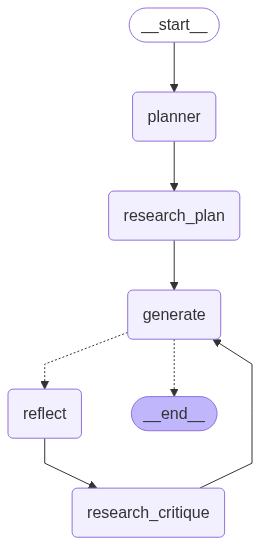

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
thread = {'configurable': {'thread_id': 1}}
task = "Write an essay about Reflection vs. Reflexion in LangGraph."

prompt = {
    "task": task,
    "max_revisions": 2,
    "revision_number": 1
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print("-" * 100)

{'planner': {'plan': "### Essay Outline: Reflection vs. Reflexion in LangGraph\n\n#### I. Introduction\n   A. Definition of key terms\n      1. Reflection: The process of introspection and self-examination in programming and language processing.\n      2. Reflexion: A term often used in cognitive science and psychology, referring to the automatic responses or reactions to stimuli.\n   B. Importance of understanding these concepts in the context of LangGraph\n   C. Thesis statement: This essay will explore the distinctions between reflection and reflexion within LangGraph, highlighting their implications for language processing and cognitive modeling.\n\n#### II. Overview of LangGraph\n   A. Brief description of LangGraph\n      1. Purpose and functionality\n      2. Applications in natural language processing (NLP) and artificial intelligence (AI)\n   B. Relevance of reflection and reflexion in LangGraph's architecture\n\n#### III. Reflection in LangGraph\n   A. Explanation of reflecti

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['The same word, two spellings. Oxford English Dictionary... The spelling reflection is now much commoner than reflexion in all uses , probably largely as a result of association with reflect v.; compare also flexion n., connection n., etc.', 'Reflexion is a word that was often considered a substitute for reflection, but is seldom used nowadays. Reflect means bending of light after touching a surface', "It better acknowledges the complexity and multi-faceted nature of the climate challenge.', 'superfluous': 'While detailed examples could potentially be trimmed, the answer covers the major considerations at a relatively high level so does not contain obvious extraneous information.'}, 'search_queries': ['overcoming political obstacles to climate action', 'transitioning major economies away from fossil fuel dependence', 'climate finance for developing countries', 'potential of nature-based solutions like reforestation'], 'references': [' ' 'name': 'ReviseAns

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_critique': {'content': ['The same word, two spellings. Oxford English Dictionary... The spelling reflection is now much commoner than reflexion in all uses , probably largely as a result of association with reflect v.; compare also flexion n., connection n., etc.', 'Reflexion is a word that was often considered a substitute for reflection, but is seldom used nowadays. Reflect means bending of light after touching a surface', "It better acknowledges the complexity and multi-faceted nature of the climate challenge.', 'superfluous': 'While detailed examples could potentially be trimmed, the answer covers the major considerations at a relatively high level so does not contain obvious extraneous information.'}, 'search_queries': ['overcoming political obstacles to climate action', 'transitioning major economies away from fossil fuel dependence', 'climate finance for developing countries', 'potential of nature-based solutions like reforestation'], 'references': [' ' 'name': 'Revis

In [17]:
print(e["generate"]["draft"])

### Reflection vs. Reflexion in LangGraph

#### I. Introduction
In the realm of programming and artificial intelligence, the terms "reflection" and "reflexion" hold significant yet distinct meanings. Reflection refers to the process of introspection and self-examination, allowing systems to analyze and modify their behavior dynamically. In contrast, reflexion, often associated with cognitive science, pertains to automatic responses or reactions to stimuli, which can be crucial in understanding human-like interactions in AI. Understanding these concepts is vital in the context of LangGraph, a framework designed for orchestrating AI agents. This essay will explore the distinctions between reflection and reflexion within LangGraph, highlighting their implications for language processing and cognitive modeling.

#### II. Overview of LangGraph
LangGraph is a graph-based orchestration framework that enables developers to create and manage AI agents effectively. Its primary purpose is to faci